In [1]:
# --- Cell 1: imports, constants, sweep ranges -------------------------------
import math
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from pathlib import Path
import os

repo_root = Path.cwd().parent          # /.../npct
data_dir  = repo_root / "data"

os.environ["DTU_CSV"]        = str(data_dir / "bt_symmetric.csv")
os.environ["ABM_CONTACTS"]   = str(data_dir / "micro_abm_contacts.csv")
os.environ["ABM30_CONTACTS"] = str(data_dir / "micro_abm_contacts30.csv")
os.environ["WORKPLACE_DAT"]  = str(data_dir / "workplace.dat")

# 3) (optional) sanity checks
for k in ["ABM_CONTACTS", "ABM30_CONTACTS", "WORKPLACE_DAT"]:
    p = Path(os.environ[k])
    print(f"{k} -> {p} (exists: {p.exists()})")

print("CWD:", Path.cwd())#

from graph_utils import load_network
from sir_functions import sir_simulation



# output dir
OUT_DIR = "../paper_figures/"
os.makedirs(OUT_DIR, exist_ok=True)

OUT_DIR_npz = "../npz_files/"
os.makedirs(OUT_DIR_npz, exist_ok=True)


# which datasets (order = A/B/C in the combined figure)
NETS = ["abm", "DTU", "workplace"]

# per-network β/γ grids (exactly as in your script)
SWEEP_RANGES = {
    "DTU": {
        "BETAS":  [0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1],
        "GAMMAS": [0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1],
    },
    "abm": {
        "BETAS":  [0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1],
        "GAMMAS": [0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1],
    },
    "workplace": {
        "BETAS":  [0.05, 0.075, 0.1, 0.15, 0.2, 0.25, 0.3],
        "GAMMAS": [0.002, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03],
    },
}

# plotting sizes
AXIS_FS = 14
TICK_FS = 11
ANNOT_FS = 9  # cell-value annotation in heatmaps


ABM_CONTACTS -> /localdata1/dial_mo/NPCT/data/micro_abm_contacts.csv (exists: True)
ABM30_CONTACTS -> /localdata1/dial_mo/NPCT/data/micro_abm_contacts30.csv (exists: True)
WORKPLACE_DAT -> /localdata1/dial_mo/NPCT/data/workplace.dat (exists: True)
CWD: /localdata1/dial_mo/NPCT/notebooks_for_plots


In [2]:
# --- Cell 2: helpers ---------------------------------------------------------
def temporal_to_adjlists(temporal_net):
    """list of nx.Graph -> list of {node: set(neigh)} per timestep"""
    return [{n: set(G.neighbors(n)) for n in G.nodes()} for G in temporal_net]

def single_run(adj_lists, beta, gamma, rng):
    """Return final attack fraction (I+R at last step) for one SIR realization."""
    n = len(adj_lists[0])
    states = np.zeros(n, dtype=np.uint8)

    # 5% initial infected, at least 1 node
    k_init = max(1, int(np.ceil(0.05 * n)))
    initial = rng.choice(n, size=k_init, replace=False)

    hist = []
    gen = sir_simulation(
        initial_infected_nodes=initial,
        adjacency_lists=adj_lists,
        start_t=0,
        beta=beta,
        gamma=gamma,
        n_timesteps=len(adj_lists),
        states=states,
        removed_edges=set(),
    )
    for st in gen:
        hist.append(st.copy())

    hist_arr = np.array(hist)  # (T, N)
    attack_curve = (np.count_nonzero(hist_arr != 0, axis=1) / n)
    return float(attack_curve[-1])

def grid_matrix(adj_lists, betas, gammas, n_reps=50, seed_base=12345):
    """
    Compute mean final attack fractions over a β×γ grid.
    Returns array shape = (len(gammas), len(betas)) to match your previous code.
    """
    n_g, n_b = len(gammas), len(betas)
    vals = np.zeros((n_g, n_b), dtype=float)
    for ig, g in enumerate(gammas):
        for ib, b in enumerate(betas):
            rng = np.random.RandomState(seed_base + ig * 1000 + ib)
            finals = [single_run(adj_lists, b, g, np.random.RandomState(rng.randint(0, 2**31-1)))
                      for _ in range(n_reps)]
            vals[ig, ib] = float(np.mean(finals))
    return vals


In [3]:
# --- Cell 3: compute grids for A/B/C in NETS --------------------------------
grids = {}
ranges = {}

for name in NETS:
    print(f"loading network: {name}")
    temporal = load_network(name)              # expects your project loader
    adj_lists = temporal_to_adjlists(temporal)

    betas  = SWEEP_RANGES[name]["BETAS"]
    gammas = SWEEP_RANGES[name]["GAMMAS"]
    ranges[name] = (betas, gammas)

    print(f"  sweeping β×γ ({len(betas)} × {len(gammas)}) …")
    mat = grid_matrix(adj_lists, betas, gammas, n_reps=50)
    grids[name] = mat
print("✓ done.")


loading network: abm


Loading ABM network: 100%|██████████| 240/240 [00:07<00:00, 33.35it/s]


  sweeping β×γ (7 × 7) …
loading network: DTU
Loading DTU graph from /localdata1/dial_mo/NPCT/data/bt_symmetric.csv with temporal_gap=300
  sweeping β×γ (7 × 7) …
loading network: workplace
[LOAD] /localdata1/dial_mo/NPCT/data/workplace.dat – Shape: (9827, 3), Columns: ['Timestamp', 'PersonId1', 'PersonId2']


Loading workplace.dat: 100%|██████████| 275/275 [00:00<00:00, 4605.67it/s]

  sweeping β×γ (7 × 7) …


✓ done.


In [4]:
# --- Cell 4: write single-network TIFF heatmaps (PLOS-friendly) --------------
def save_single_heatmap_tiff(name, mat, betas, gammas, out_path):
    fig, ax = plt.subplots(figsize=(4.3, 4.0), dpi=150)  # size won't matter; we export @600 dpi
    im = ax.imshow(mat.T, origin="lower", vmin=0, vmax=1, cmap="viridis")

    # ticks/labels
    ax.set_xticks(range(len(gammas)))
    ax.set_yticks(range(len(betas)))
    ax.set_xticklabels([f"{g:.3f}" for g in gammas], rotation=45, ha="right", fontsize=TICK_FS)
    ax.set_yticklabels([f'{b:.3f}'.rstrip('0').rstrip('.') for b in betas], fontsize=TICK_FS)
    ax.set_xlabel("γ", fontsize=AXIS_FS)
    ax.set_ylabel("β", fontsize=AXIS_FS)

    # annotate each cell with % (like your old plot)
    for i in range(mat.shape[0]):              # i over gammas
        for j in range(mat.shape[1]):          # j over betas
            v = mat[i, j]
            ax.text(i, j, f"{int(round(v*100)):d}%", ha="center", va="center",
                    fontsize=ANNOT_FS, color=("white" if v > 0.5 else "black"))

    cbar = fig.colorbar(im, ax=ax, fraction=0.048, pad=0.04)
    cbar.set_label("Final infected [%]", fontsize=AXIS_FS)
    cbar.ax.tick_params(labelsize=TICK_FS)
    # convert 0..1 → 0..100 on the colorbar ticks
    ticks = cbar.get_ticks()
    cbar.set_ticks(ticks)
    cbar.set_ticklabels([f"{int(t*100)}" for t in ticks])

    # fig.savefig(
    #     out_path,
    #     dpi=600,
    #     format="tiff",
    #     pil_kwargs={"compression": "tiff_lzw"},
    #     bbox_inches="tight"
    # )
    # plt.close(fig)
    # print(f"✓ saved {out_path.name}")

# for name in NETS:
#     mat = grids[name]
#     betas, gammas = ranges[name]
#     out_tif = RESULTS_DIR / f"heatmap_{name}.tif"
#     save_single_heatmap_tiff(name, mat, betas, gammas, out_tif)


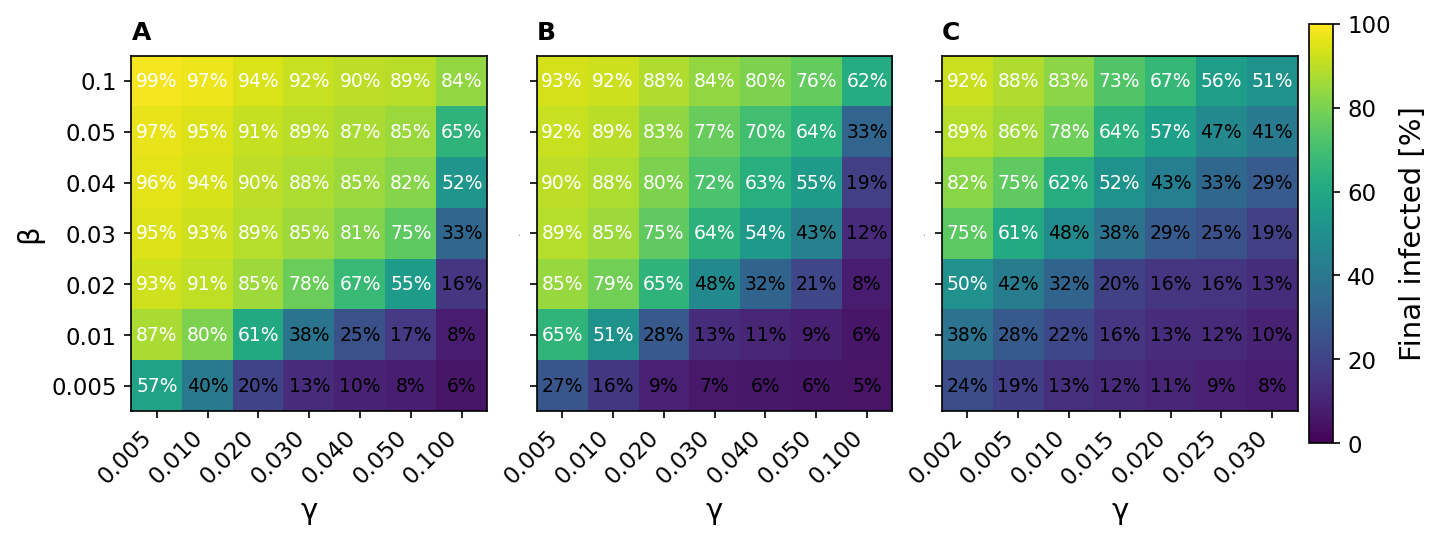

✓ saved ../paper_figures/Fig11.tif


In [5]:
# --- Cell 5: 1×3 combined TIFF (A/B/C, shared colorbar on the right) ---------
def fig_beta_gamma_threepanel(grids, ranges, order, out_path, letters="ABC"):
    # full-page width for PLOS (≈7.5 in), low height to keep aspect nice
    fig, axes = plt.subplots(
        nrows=1, ncols=3,
        figsize=(9.5, 4.8),  # ~19.05 cm × 7.1 cm
        dpi=150, constrained_layout=True
    )

    vmin, vmax = 0.0, 1.0
    cm = plt.get_cmap("viridis")

    for j, name in enumerate(order):
        ax = axes[j]
        mat = grids[name]
        betas, gammas = ranges[name]

        im = ax.imshow(mat.T, origin="lower", vmin=vmin, vmax=vmax, cmap=cm)

        # ticks/labels
        ax.set_xticks(range(len(gammas)))
        ax.set_yticks(range(len(betas)))
        ax.set_xticklabels([f"{g:.3f}" for g in gammas], rotation=45, ha="right", fontsize=TICK_FS)
        ax.set_yticklabels([f'{b:.3f}'.rstrip('0').rstrip('.') for b in betas], fontsize=TICK_FS)
        ax.set_xlabel("γ", fontsize=AXIS_FS)
        # y-label only on first subplot (like the other multi-panels)
        ax.set_ylabel("β", fontsize=AXIS_FS if j == 0 else 0)
        if j != 0:
            ax.tick_params(axis="y", labelleft=False)

        # cell annotations
        for i in range(mat.shape[0]):
            for k in range(mat.shape[1]):
                v = mat[i, k]
                ax.text(i, k, f"{int(round(v*100)):d}%", ha="center", va="center",
                        fontsize=ANNOT_FS, color=("white" if v > 0.5 else "black"))

        # panel letters (top-left inside)
        ax.text(-0.0, 1.03, letters[j], transform=ax.transAxes,
                fontsize=12, fontweight="bold", ha="left", va="bottom")

    # shared colorbar at row end (slimmer + slightly shorter)
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(norm=norm, cmap=cm); sm.set_array([])
    cbar = fig.colorbar(
        sm,
        ax=axes.ravel().tolist(),
        location="right",
        fraction=0.020,     # thinner bar (was 0.035)
        pad=0.010,          # tighter gap (was 0.02)
        aspect=18,          # controls length/width ratio (smaller => thinner)
        shrink=0.88         # make it a bit shorter vertically
    )
    cbar.set_label("Final infected [%]", fontsize=AXIS_FS)
    cbar.ax.tick_params(labelsize=TICK_FS)

    # show 0–100 on ticks (not 0–1)
    ticks = np.linspace(0, 1, 6)  # 0, .2, .4, .6, .8, 1.0
    cbar.set_ticks(ticks)
    cbar.set_ticklabels([f"{int(t*100)}" for t in ticks])


    # export TIFF (600 dpi, LZW)
    fig.savefig(
        out_path,
        dpi=600,
        format="tiff",
        pil_kwargs={"compression": "tiff_lzw"},
        bbox_inches="tight"
    )
    plt.show()
    print(f"✓ saved {out_path}")

combined_tif = OUT_DIR + "Fig11.tif"
fig_beta_gamma_threepanel(grids, ranges, NETS, combined_tif)


In [6]:
# Cell 1: imports + style knobs
from __future__ import annotations
import math
from pathlib import Path
from typing import Dict, List, Tuple

import joblib
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import matplotlib.colors as mcolors

# project-local
from graph_utils import load_network
from sir_functions import sir_simulation


# Style
ANNOT_FS   = 9     # small annotations
AXIS_FS    = 12    # axis labels
TICK_FS    = 10    # tick labels
LEGEND_FS  = 8     # legend
LINE_W     = 1.5
FILL_ALPHA = 0.20

plt.rcParams.update({
    "axes.labelsize": AXIS_FS,
    "xtick.labelsize": TICK_FS,
    "ytick.labelsize": TICK_FS,
    "legend.fontsize": LEGEND_FS,
    "font.size": ANNOT_FS,
})


In [7]:
# Cell 2: network order and (β, γ) sets
# Order for combined 1×3: ABM → DTU → Office
NETS = ["abm", "DTU", "workplace"]

NET_PARAMS: Dict[str, List[Tuple[float, float]]] = {
    "DTU": [
        (0.01, 0.001),
        (0.01, 0.005),
        (0.02, 0.001),
        (0.02, 0.005),
        (0.04, 0.005),
        (0.05, 0.01),
    ],
    "abm": [
        (0.01, 0.005),
        (0.01, 0.01),
        (0.02, 0.009),
        (0.02, 0.01),
        (0.03, 0.009),
        (0.03, 0.01),
    ],
    "workplace": [
        (0.10, 0.005),
        (0.20, 0.005),
        (0.30, 0.005),
        (0.10, 0.010),
        (0.20, 0.010),
        (0.30, 0.010),
    ],
}


In [8]:
# Cell 3: helpers
PCT_INIT = 0.05
N_REPS   = 500
BATCH    = 50
N_JOBS   = 10

def temporal_to_adjlists(temporal_net: List[nx.Graph]) -> List[Dict[int, set]]:
    return [{n: set(G.neighbors(n)) for n in G.nodes()} for G in temporal_net]

def _single_run_I(adj_lists: List[Dict[int, set]], beta: float, gamma: float, rng: np.random.RandomState) -> np.ndarray:
    n = len(adj_lists[0])
    states = np.zeros(n, dtype=np.uint8)
    k_init = max(1, math.ceil(PCT_INIT * n))
    initial = rng.choice(n, size=k_init, replace=False)

    series = []
    for st in sir_simulation(
        initial_infected_nodes=initial,
        adjacency_lists=adj_lists,
        start_t=0,
        beta=beta,
        gamma=gamma,
        n_timesteps=len(adj_lists),
        states=states,
        removed_edges=set(),
    ):
        series.append(np.count_nonzero(st == 1) / n)  # infected fraction
    return np.array(series)

def simulate_infected(adj_lists: List[Dict[int, set]], beta: float, gamma: float, n_reps: int = N_REPS):
    seeds = [hash((beta, gamma, r)) & 0xFFFFFFFF for r in range(n_reps)]
    batches = [seeds[i:i+BATCH] for i in range(0, n_reps, BATCH)]

    def _batch_do(batch_seeds):
        return [_single_run_I(adj_lists, beta, gamma, np.random.RandomState(s)) for s in batch_seeds]

    res = joblib.Parallel(n_jobs=N_JOBS, backend="loky")(joblib.delayed(_batch_do)(b) for b in batches)
    curves = [c for chunk in res for c in chunk]
    arr = np.stack(curves)  # (n_reps, T)
    return arr.mean(axis=0), arr.std(axis=0)


In [9]:
# Cell 4: per-network PDFs
def plot_infected_curves_single(net_name: str, params: List[Tuple[float, float]], out_pdf: Path):
    temporal = load_network(net_name)
    adj_lists = temporal_to_adjlists(temporal)

    fig, ax = plt.subplots(figsize=(4.3, 3.8), dpi=300)
    colors = plt.get_cmap("tab10").colors

    for i, (beta, gamma) in enumerate(params):
        mean_curve, std_curve = simulate_infected(adj_lists, beta, gamma, N_REPS)
        t = np.arange(len(mean_curve))
        line, = ax.plot(t, mean_curve * 100, lw=LINE_W, ls="--",
                        label=f"β={beta:.3f}, γ={gamma:.3f}", color=colors[i % len(colors)])
        ax.fill_between(t, (mean_curve - std_curve) * 100, (mean_curve + std_curve) * 100,
                        color=line.get_color(), alpha=FILL_ALPHA)

    ax.set_xlim(0, len(adj_lists) - 1)
    ax.set_ylim(0, 100)
    ax.set_xlabel("Time [hour]")
    ax.set_ylabel("Infections [%]")
    ax.grid(alpha=0.25, linestyle=":")
    ax.legend(ncol=2 if len(params) > 4 else 1, fontsize=LEGEND_FS, frameon=False)

    fig.tight_layout()
    # fig.savefig(out_pdf, dpi=300, format="pdf", bbox_inches="tight")
    # plt.close(fig)
    # print(f"✓ saved {out_pdf.name}")

# run for all three
# for net in NETS:
#     plot_infected_curves_single(net, NET_PARAMS[net], OUT_DIR / f"infected_curves_{net}.pdf")


In [10]:
# Cell 4a (fixed): precompute & cache infected-curves for all nets/params (no plotting)

from pathlib import Path
import numpy as np

def compute_infected_curves_all(net_order, net_params, *, n_reps=None, force=False):
    """
    Returns a nested dict:
      results[net][(beta, gamma)] = (t_array, mean_curve, std_curve)
    and writes per-network caches: infected_curves_<net>.npz
    """
    
    # choose repetitions
    if n_reps is None:
        n_reps = int(globals().get("N_REPS", 500))

    results = {}

    for net_name in net_order:
        cache_path = Path(OUT_DIR_npz) / f"infected_curves_{net_name}.npz"

        if cache_path.exists() and not force:
            # load cached
            data = np.load(cache_path, allow_pickle=True)
            keys = [tuple(map(float, k.split(","))) for k in data["keys"]]
            vals = data["vals"]
            res = {}
            for (beta, gamma), (t, mean_curve, std_curve) in zip(keys, vals):
                res[(beta, gamma)] = (t, mean_curve, std_curve)
            results[net_name] = res
            print(f"↻ loaded cache: {cache_path.name}")
            continue

        # (re)compute
        temporal = load_network(net_name)
        adj_lists = temporal_to_adjlists(temporal)

        res = {}
        for beta, gamma in net_params[net_name]:
            mean_curve, std_curve = simulate_infected(adj_lists, beta, gamma, n_reps=n_reps)
            t = np.arange(len(mean_curve))
            res[(beta, gamma)] = (t, mean_curve, std_curve)

        results[net_name] = res

        # persist compactly
        keys = np.array([f"{b:.6f},{g:.6f}" for (b, g) in res.keys()], dtype=object)
        vals = np.array([res[k] for k in res.keys()], dtype=object)  # each is (t, mean, std)
        np.savez_compressed(cache_path, keys=keys, vals=vals)
        print(f"✓ cached: {cache_path.name}")

    return results

# run once (set force=True to recompute)
INF_CURVES = compute_infected_curves_all(NETS, NET_PARAMS, force=False)


↻ loaded cache: infected_curves_abm.npz
↻ loaded cache: infected_curves_DTU.npz
↻ loaded cache: infected_curves_workplace.npz


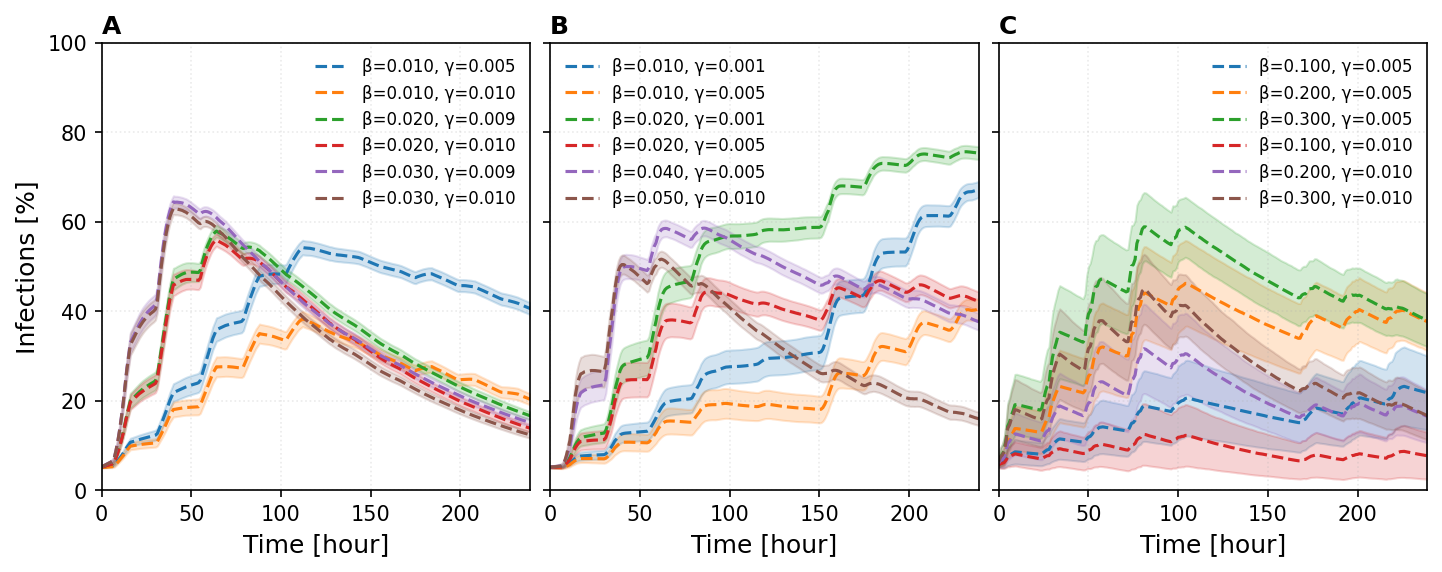

✓ saved ../paper_figures/Fig12.tif


In [11]:
# Cell 5 (version with per-panel legends inside panels)

import matplotlib.pyplot as plt
import numpy as np

LINE_W     = globals().get("LINE_W", 1.5)
FILL_ALPHA = globals().get("FILL_ALPHA", 0.20)
AXIS_FS    = globals().get("AXIS_FS", 14)
TICK_FS    = globals().get("TICK_FS", 11)
LEGEND_FS  = globals().get("LEGEND_FS", 8)
OUT_DIR    = globals().get("OUT_DIR", globals().get("RESULTS_DIR"))

def _coerce_1d_float(a):
    a = np.asarray(a, dtype=object)
    if a.dtype == object:
        a = np.array([np.asarray(v).astype(float).ravel() for v in a], dtype=object)
        try:
            a = np.concatenate(a.tolist())
        except Exception:
            a = np.array(a.tolist(), dtype=float)
    else:
        a = a.astype(float, copy=False)
    return a.ravel()

def _lookup_curve(res_dict, beta, gamma, tol=5e-7):
    if (beta, gamma) in res_dict:
        return res_dict[(beta, gamma)]
    for (b, g), triplet in res_dict.items():
        if abs(b - beta) <= tol and abs(g - gamma) <= tol:
            return triplet
    raise KeyError((beta, gamma))

def fig_infected_threepanel_legends(net_order, net_params, curves, out_tif, letters="ABC"):
    fig, axes = plt.subplots(1, 3, figsize=(9.5, 3.7), dpi=150, constrained_layout=True)
    colors = plt.get_cmap("tab10").colors

    legend_locs = ["upper right", "upper left", "upper right"]

    for j, net_name in enumerate(net_order):
        ax = axes[j]
        res = curves[net_name]
        pairs = list(net_params[net_name])
        handles, labels = [], []

        for i, (beta, gamma) in enumerate(pairs):
            t_raw, mean_raw, std_raw = _lookup_curve(res, beta, gamma)
            t = _coerce_1d_float(t_raw)
            mean_curve = _coerce_1d_float(mean_raw)
            std_curve  = _coerce_1d_float(std_raw)

            line, = ax.plot(t, mean_curve * 100, lw=LINE_W, ls="--",
                            color=colors[i % len(colors)],
                            label=f"β={beta:.3f}, γ={gamma:.3f}")
            ax.fill_between(t, (mean_curve - std_curve) * 100,
                               (mean_curve + std_curve) * 100,
                            color=line.get_color(), alpha=FILL_ALPHA)

            handles.append(line)
            labels.append(f"β={beta:.3f}, γ={gamma:.3f}")

        ax.set_xlim(float(t.min()), float(t.max()))
        ax.set_ylim(0, 100)
        ax.set_xlabel("Time [hour]", fontsize=AXIS_FS)
        if j == 0:
            ax.set_ylabel("Infections [%]", fontsize=AXIS_FS)
        else:
            ax.tick_params(axis="y", labelleft=False)
        ax.grid(alpha=0.25, linestyle=":")

        # panel letter
        ax.text(-0.0, 1.01, letters[j], transform=ax.transAxes,
                fontsize=12, fontweight="bold", ha="left", va="bottom")

        # add legend in the requested location
        ax.legend(handles, labels, fontsize=LEGEND_FS, frameon=False, loc=legend_locs[j])

    # export TIFF (600 dpi, LZW)
    fig.savefig(
        out_tif,
        dpi=600,
        format="tiff",
        pil_kwargs={"compression": "tiff_lzw"},
        bbox_inches="tight"
    )
    plt.show()
    print(f"✓ saved {out_tif}")


# Example usage:
combined_tif = OUT_DIR + "Fig12.tif"
fig_infected_threepanel_legends(NETS, NET_PARAMS, INF_CURVES, combined_tif)
